# Notebook 010: Boston Property Assessments EDA and feature enrichment

This notebooks contains preliminary EDA for Boston property assessments, fiscal years 2013-2019.

Activities completed in this notebook include:

1. Merge all fiscal year records into a single datafile/dataframe
2. Match corresponding latitude and longitude coordinates to each property assessment record
3. Identify missingness of geo-location coordinates (i.e. unmatched remaining assessments)
4. Perform EDA on the dataset
5. Enrich the dataset with additional features (e.g. census-tract indicators, multi-year change rates, etc.)
6. Generate new summary datasets ultimately used for generating engineered features in our final predictive analysis

In [88]:
import urllib
import os
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/property'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim')

readfile_prop_dir = os.path.join(READDIR_ROOT, 'property')
readfile_sam = os.path.join(READDIR_ROOT, 'boston/sam-addresses.csv')
readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_prop_dir, readfile_sam, readfile_zipshapes
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/property
	../data/raw/boston/sam-addresses.csv
	../data/raw/shapefile/zipcodes/ZIP_Codes.shp


In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)

In [4]:
# read in SAM address data and related shapefiles
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)
gdf_tracts = gpd.read_file(readfile_tractshapes)
gdf_hoods = gpd.read_file(readfile_hoodshapes)
gdf_zonesubs = gpd.read_file(readfile_zonesubshapes)

# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)

In [5]:
# check info of SAM dataframe
df_sam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398693 entries, 0 to 398692
Data columns (total 27 columns):
X                       398693 non-null float64
Y                       398693 non-null float64
SAM_ADDRESS_ID          398693 non-null object
RELATIONSHIP_TYPE       398693 non-null object
BUILDING_ID             398693 non-null object
FULL_ADDRESS            398693 non-null object
STREET_NUMBER           398693 non-null object
IS_RANGE                398693 non-null object
RANGE_FROM              26176 non-null object
RANGE_TO                26176 non-null object
UNIT                    270097 non-null object
FULL_STREET_NAME        398693 non-null object
STREET_ID               398693 non-null object
STREET_PREFIX           398693 non-null object
STREET_BODY             398693 non-null object
STREET_SUFFIX_ABBR      394515 non-null object
STREET_FULL_SUFFIX      394515 non-null object
STREET_SUFFIX_DIR       398693 non-null object
STREET_NUMBER_SORT      398693 non-null obj

In [6]:
%%time
#####################################################################
## READ IN ALL PROPERTY ASSESSMENT FILES TO DICT OF DATAFRAME OBJECTS
#####################################################################

# read all property assessment datafiles into dictionary
property_file_list = os.listdir(readfile_prop_dir)
prop_df_dict = {
    '20{0}'.format(filename[2:4]): pd.read_csv(
        os.path.join(readfile_prop_dir, filename),
        dtype=str
    )
    for filename in property_file_list
}
prop_df_dict_keys = sorted(list(prop_df_dict.keys()))

CPU times: user 8.77 s, sys: 392 ms, total: 9.16 s
Wall time: 8.75 s


In [7]:
# inspect df shapes and columns
print('fiscal year\tdataframe shape\n')

for key in prop_df_dict_keys:
    print('{0}\t\t{1}'.format(key, prop_df_dict[key].shape))

fiscal year	dataframe shape

2013		(165608, 54)
2014		(164091, 56)
2015		(168115, 56)
2016		(169199, 77)
2017		(170910, 75)
2018		(172841, 75)
2019		(174668, 75)


In [8]:
# check for differences among dataframe columns year over year
# these will need to be standardized before concatenating dfs
prop_df_columns_dict = {
    year: list(dataframe.columns)
    for year, dataframe in prop_df_dict.items() 
}

column_changes_by_year = {
    year: [
        list(set(prop_df_columns_dict[str(int(year)-1)]).difference(set(prop_df_columns_dict[year]))),
        list(set(prop_df_columns_dict[year]).difference(set(prop_df_columns_dict[str(int(year)-1)])))
    ] for year in prop_df_dict_keys[1:]
}

print('Changes in dataframe column names by fiscal year assessment report:\n')
for key in column_changes_by_year.keys():
    print(key)
    print('  prior year columns removed:\n   {0}'.format(column_changes_by_year[key][0]))
    print('  current year columns added:\n   {0}'.format(column_changes_by_year[key][1]))
    print()

Changes in dataframe column names by fiscal year assessment report:

2014
  prior year columns removed:
   ['MAIL_ZIPCODE', 'PID', 'MAIL CS', 'U_NUM_PARK', 'MAIL_ADDRESS']
  current year columns added:
   ['full_address', 'Owner_MAIL_ZIPCODE', 'Owner_MAIL_ADDRESS', 'Location', 'Owner_MAIL_CS', 'Parcel_ID', 'Unnamed: 55']

2015
  prior year columns removed:
   ['Owner_MAIL_ZIPCODE', 'Owner_MAIL_ADDRESS', 'Owner_MAIL_CS', 'Parcel_ID', 'Unnamed: 55']
  current year columns added:
   ['OWNER_MAIL_ZIPCODE', 'PID', 'OWNER_MAIL_CS', 'OWNER_MAIL_ADDRESS', 'U_NUM_PARK']

2016
  prior year columns removed:
   ['full_address', 'OWNER_MAIL_ZIPCODE', 'U_KIT_TYPE', 'OWNER_MAIL_CS', 'OWNER_MAIL_ADDRESS', 'Location']
  current year columns added:
   ['R_INT_FIN', 'R_KITCH_STYLE3', 'R_BTH_STYLE2', 'U_INT_CND', 'U_VIEW', 'R_INT_CND', 'R_VIEW', 'MAIL_ADDRESS', 'U_KITCH_TYPE', 'R_KITCH_STYLE2', 'U_INT_FIN', 'LONGITUDE', 'R_OVRALL_CND', 'R_BTH_STYLE', 'U_KITCH_STYLE', 'U_BTH_STYLE', 'R_KITCH_STYLE', 'S_EXT

In [9]:
# list of columns to add to dataframes for years in which they are missing
add_columns_list = [
    'LATITUDE', 'LONGITUDE', 
    'Location', 'full_address',
    'MAIL_ADDRESSEE', 'GIS_ID',
    'U_NUM_PARK', 'R_VIEW', 'R_INT_CND',
    'R_BTH_STYLE3', 'U_KITCH_STYLE',
    'U_BTH_STYLE3', 'S_EXT_CND',
    'R_KITCH_STYLE', 'U_BTH_STYLE',
    'R_EXT_CND', 'R_KITCH_STYLE3',
    'R_INT_FIN', 'R_BTH_STYLE',
    'R_BTH_STYLE2', 'R_OVRALL_CND',
    'R_KITCH_STYLE2', 'U_INT_CND',
    'U_VIEW',  'U_INT_FIN', 'U_BTH_STYLE2'
]

# mapping dict to rename column names with variations in spelling
rename_columns_dict = {
    'Parcel_ID': 'PID',
    'OWNER_MAIL_ZIPCODE': 'MAIL_ZIPCODE',
    'Owner_MAIL_ZIPCODE': 'MAIL_ZIPCODE',
    'OWNER_MAIL_ADDRESS': 'MAIL_ADDRESS',
    'Owner_MAIL_ADDRESS': 'MAIL_ADDRESS',
    'OWNER_MAIL_CS': 'MAIL CS',
    'Owner_MAIL_CS': 'MAIL CS',
    'U_KIT_TYPE': 'U_KITCH_TYPE',
}

# list of columns to drop if they exist in df
drop_columns = ['Unnamed: 55']

In [10]:
############################################################
## MODIFY DATAFRAME COLUMNS TO MATCH FOR ALL FISCAL YEAR DFS
############################################################

# add fiscal year row values to each dataframe
for year in prop_df_dict_keys:
    prop_df_dict[year]['fiscal-year'] = year

# add columns to dataframes where they are missing
for year in prop_df_dict_keys:
    for column in add_columns_list:
        if column not in prop_df_dict[year]:
            prop_df_dict[year][column] = np.nan

# remap column names in dataframes where there are variations in naming
for year in prop_df_dict_keys:
    prop_df_dict[year] = prop_df_dict[year].rename(columns=rename_columns_dict)
    
# drop bad columns in drop_columns list if they exist
for year in prop_df_dict_keys:
    prop_df_dict[year] = prop_df_dict[year].drop(columns=drop_columns, errors='ignore')

In [11]:
# check results for matching df widths
print('fiscal year\tdataframe shape\n')

for key in prop_df_dict_keys:
    print('{0}\t\t{1}'.format(key, prop_df_dict[key].shape))

fiscal year	dataframe shape

2013		(165608, 80)
2014		(164091, 80)
2015		(168115, 80)
2016		(169199, 80)
2017		(170910, 80)
2018		(172841, 80)
2019		(174668, 80)


In [12]:
# check year by year column diffs again to ensure not diffs for any years
prop_df_columns_dict_check = {
    year: list(dataframe.columns)
    for year, dataframe in prop_df_dict.items() 
}

column_changes_by_year_check = {
    year: [
        list(set(prop_df_columns_dict_check[str(int(year)-1)]).difference(set(prop_df_columns_dict_check[year]))),
        list(set(prop_df_columns_dict_check[year]).difference(set(prop_df_columns_dict_check[str(int(year)-1)])))
    ] for year in prop_df_dict_keys[1:]
}

print('Changes in dataframe column names by fiscal year assessment report:\n')
for key in column_changes_by_year_check.keys():
    print(key)
    print('  prior year columns removed:\n   {0}'.format(column_changes_by_year_check[key][0]))
    print('  current year columns added:\n   {0}'.format(column_changes_by_year_check[key][1]))
    print()

Changes in dataframe column names by fiscal year assessment report:

2014
  prior year columns removed:
   []
  current year columns added:
   []

2015
  prior year columns removed:
   []
  current year columns added:
   []

2016
  prior year columns removed:
   []
  current year columns added:
   []

2017
  prior year columns removed:
   []
  current year columns added:
   []

2018
  prior year columns removed:
   []
  current year columns added:
   []

2019
  prior year columns removed:
   []
  current year columns added:
   []



In [13]:
########################################################
## CONCATENATE ALL FISCAL YEAR DATAFRAMES INTO SINGLE DF 
########################################################

# The most recent fiscal year is used as the starting reference frame
prop_df = pd.concat(
    [prop_df_dict[year] for year in prop_df_dict_keys[::-1]],
    sort=False,
    ignore_index=True
)

In [14]:
# inspect resulting consolidated dataframe
print(prop_df.info())
prop_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185432 entries, 0 to 1185431
Data columns (total 80 columns):
PID                1185432 non-null object
CM_ID              528555 non-null object
GIS_ID             687305 non-null object
ST_NUM             1185432 non-null object
ST_NAME            1185432 non-null object
ST_NAME_SUF        1182792 non-null object
UNIT_NUM           438126 non-null object
ZIPCODE            1185407 non-null object
PTYPE              1185426 non-null object
LU                 1185431 non-null object
OWN_OCC            1185388 non-null object
OWNER              1185432 non-null object
MAIL_ADDRESSEE     610517 non-null object
MAIL_ADDRESS       1185432 non-null object
MAIL CS            1185432 non-null object
MAIL_ZIPCODE       1185430 non-null object
AV_LAND            1185430 non-null object
AV_BLDG            1185432 non-null object
AV_TOTAL           1185432 non-null object
GROSS_TAX          1185432 non-null object
LAND_SF            1161487 non-

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,fiscal-year,LATITUDE,LONGITUDE,Location,full_address
0,0502550008,502550000,502550000,87,BEACON,ST,2-F,2108,102,CD,...,N,1,N,G,A,2019,NaN,NaN,NaN,NaN
1,0502550010,502550000,502550000,87,BEACON,ST,2-R,2108,102,CD,...,N,1,N,A,A,2019,NaN,NaN,NaN,NaN
2,0502550012,502550000,502550000,87,BEACON,ST,3-F,2108,102,CD,...,N,1,N,A,G,2019,NaN,NaN,NaN,NaN
3,0502550014,502550000,502550000,87,BEACON,ST,3-R,2108,102,CD,...,N,1,S,A,G,2019,NaN,NaN,NaN,NaN
4,0502550016,502550000,502550000,87,BEACON,ST,4,2108,102,CD,...,C,2,N,E,G,2019,NaN,NaN,NaN,NaN


In [15]:
# unpack 'Location' column coordinates to lat/lon columns and fill blanks
prop_df['LATITUDE'] = prop_df['LATITUDE'].fillna(
    prop_df['Location'].copy().str.split('(').str.get(1).str.split('|').str.get(0)
)
prop_df['LONGITUDE'] = prop_df['LONGITUDE'].fillna(
    prop_df['Location'].copy().str.split('|').str.get(1).str.split(')').str.get(0)
)

In [16]:
# check PID values to see unwanted characters
prop_df['PID'].value_counts().sort_index()[:6]

0100001000     3
0100001000_    4
0100002000     3
0100002000_    4
0100003000     3
0100003000_    4
Name: PID, dtype: int64

In [17]:
# remove all non-numeric characters from PID values
prop_df['PID'] = prop_df['PID'].str.replace(r'[^0-9]', '')

# generate a match key for all PIDs with available lats/lons
PID_coord_match_key = prop_df.groupby('PID').agg(
    {
        'LATITUDE': 'first',
        'LONGITUDE': 'first'
    }
)

# convert lat/lon from string to floats
PID_coord_match_key = PID_coord_match_key.astype(float)

# drop zero values
PID_coord_match_key = PID_coord_match_key.replace(0, np.nan)

# store match rate
PID_matchrate = 100 - sum(PID_coord_match_key['LATITUDE'].isnull()) / len(PID_coord_match_key) * 100

# print results to determine how many PIDs still need lat/lon matching
print(
    'Of the {0:,} unique PIDs contained in the {1:,} row consolidated '\
    'property assessment, the following number of PIDs have NO associated '\
    'lat/long coordinates:\n\n\t{2:,}\t{3:.2f}%'.format(
        len(PID_coord_match_key),
        len(prop_df),
        sum(PID_coord_match_key['LATITUDE'].isnull()),
        100 - PID_matchrate
    )
)

Of the 174,167 unique PIDs contained in the 1,185,432 row consolidated property assessment, the following number of PIDs have NO associated lat/long coordinates:

	17,541	10.07%


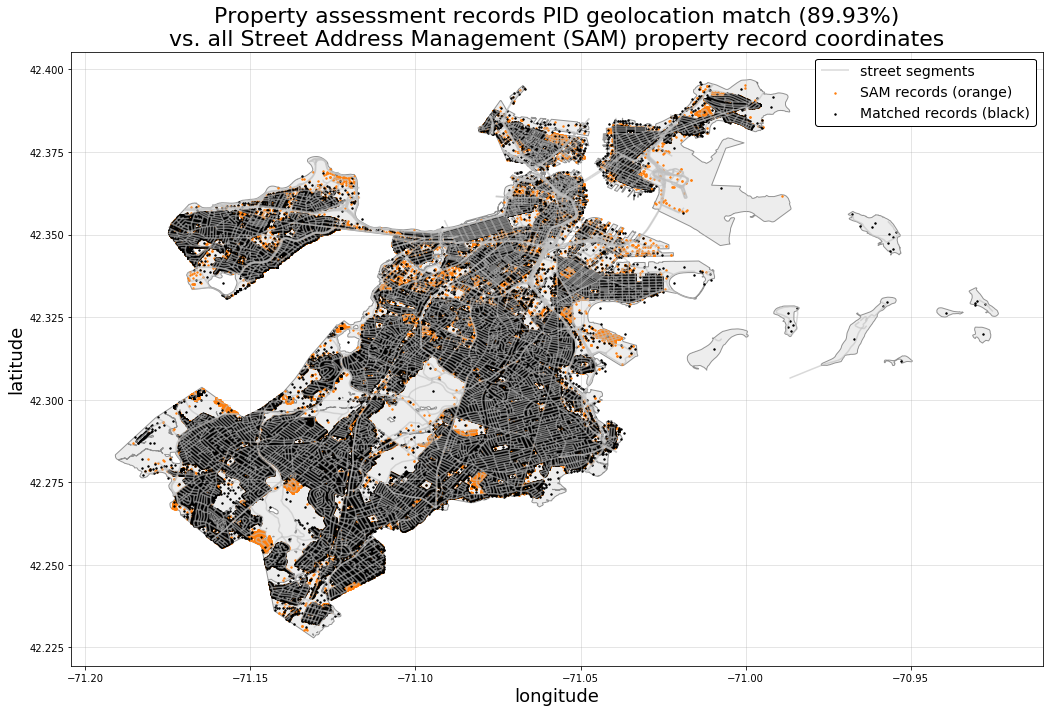

CPU times: user 5.99 s, sys: 95.4 ms, total: 6.09 s
Wall time: 5.59 s


In [18]:
%%time

# Plot PID coordinates from consolidated property dataset over top
# of SAM addresses master list to identify what areas are missing and
# potential sources of bias in our data

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records PID geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(PID_matchrate),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    PID_coord_match_key['LONGITUDE'].dropna(), PID_coord_match_key['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=18)
plt.ylabel('latitude', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
plt.show();

In [19]:
##########################################
## MATCH PID LAT/LONS BY PID ALL FOR YEARS
##########################################
pid_lat_map = dict(zip(PID_coord_match_key.index, PID_coord_match_key['LATITUDE'].values))
pid_lon_map = dict(zip(PID_coord_match_key.index, PID_coord_match_key['LONGITUDE'].values))

prop_df['LATITUDE'] = prop_df['PID'].copy().map(pid_lat_map)
prop_df['LONGITUDE'] = prop_df['PID'].copy().map(pid_lon_map)

In [20]:
# Summarize total property records and lat/lon match rate by year
print(
    'For each fiscal year, there are:\n\nyear\tproperty records\tunmatched '\
    'records\tmatch rate'
)
for year in prop_df_dict_keys:
    print(
        '{0}\t{1:,}\t\t\t{2:,}\t\t\t{3:.2f}%'.format(
            year,
            len(prop_df[prop_df['fiscal-year']==year]),
            sum(prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()),
            100 - sum(
                prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()
            ) / len(prop_df[prop_df['fiscal-year']==year]) * 100 
        )
    )

For each fiscal year, there are:

year	property records	unmatched records	match rate
2013	165,608			6,697			95.96%
2014	164,091			7,209			95.61%
2015	168,115			9,365			94.43%
2016	169,199			10,474			93.81%
2017	170,910			12,477			92.70%
2018	172,841			14,914			91.37%
2019	174,668			16,882			90.33%


## Attempt to match remaining property record locations using SAM data

Now that most property records have been match to lat/lon coordinates, we will attempt to match the remaining using the data available in the SAM records file.

In [21]:
%%time

# clean/normalize match value column data in prop df to ensure consistent matching
prop_df['ST_NAME_SUF'] = prop_df['ST_NAME_SUF'].fillna('').str.strip()
prop_df['ZIPCODE'] = prop_df['ZIPCODE'].fillna('').str.strip().str.replace(r'[^0-9]', '')
prop_df['ZIPCODE'] = ('00000' + prop_df['ZIPCODE']).str[-5:]

# create property match address in all lowercase
prop_df['addr_lower'] = (
    prop_df['ST_NUM'].fillna('').str.strip() + ' ' + \
    prop_df['ST_NAME'].fillna('').str.strip() + ' ' + \
    prop_df['ST_NAME_SUF'].fillna('').str.strip()
).str.strip().str.lower()

# create property street zip match in all lowers
prop_df['st_zip_lower'] = (
    prop_df['ST_NAME'].fillna('').str.strip() + ' ' + \
    prop_df['ST_NAME_SUF'].fillna('').str.strip() + ' ' + \
    prop_df['ZIPCODE'].fillna('').str.strip()
).str.strip().str.lower()

# create property record indicator
prop_df['is_prop'] = 1

# clean/normalize match value column data in SAM df to ensure consistent matching
df_sam['PID'] = df_sam['PARCEL'].copy().str.strip()
# df_sam['GIS_ID'] = df_sam['PARCEL'].copy().str[1:]

# create SAM match address in all lowercase
df_sam['addr_lower'] = (
    df_sam['STREET_NUMBER'].fillna('').str.strip() + ' ' + \
    df_sam['FULL_STREET_NAME'].fillna('').str.strip()
).str.strip().str.lower()

# create SAM street zip match in all lowers
df_sam['st_zip_lower'] = (
    df_sam['FULL_STREET_NAME'].fillna('').str.strip()  + ' ' + \
    df_sam['ZIP_CODE'].fillna('').str.strip()
).str.strip().str.lower()

# rename SAM lat lon columns for merging with property df
df_sam['LONGITUDE'] = df_sam['X']
df_sam['LATITUDE'] = df_sam['Y']

# create SAM record indicator
df_sam['is_sam'] = 1

CPU times: user 4.19 s, sys: 199 ms, total: 4.39 s
Wall time: 4.38 s


In [22]:
# generate matching tables for each SAM to property match method
df_PID_unique = df_sam.groupby('PID').agg(
    {
        'LONGITUDE': 'first',
        'LATITUDE': 'first',
    }
)
df_addr_unique = df_sam.groupby('addr_lower').agg(
    {
        'LONGITUDE': 'first',
        'LATITUDE': 'first',
    }
)
df_st_zip_unique = df_sam.groupby('st_zip_lower').agg(
    {
        'LONGITUDE': 'first',
        'LATITUDE': 'first',
    }
)

In [23]:
# create subset of unmatched property records all years
prop_df_nomatch = prop_df.loc[prop_df['LATITUDE'].isnull()].copy()

print(
    'The starting set of unmatched records prior to attempting other '\
    'match methods contains the following number of records:\n\n\t{0:,}'\
    ''.format(
        len(prop_df_nomatch)
    )
)

The starting set of unmatched records prior to attempting other match methods contains the following number of records:

	78,018


In [24]:
##################################
# map lat and lon based on SAM PID
##################################

sam_pid_lat_map = dict(zip(df_PID_unique.index, df_PID_unique['LATITUDE'].values))
sam_pid_lon_map = dict(zip(df_PID_unique.index, df_PID_unique['LONGITUDE'].values))

prop_df_nomatch['LATITUDE'] = prop_df_nomatch['PID'].copy().map(sam_pid_lat_map)
prop_df_nomatch['LONGITUDE'] = prop_df_nomatch['PID'].copy().map(sam_pid_lon_map)

In [25]:
# create additional subset of unmatched property records all years
prop_df_match = prop_df_nomatch.loc[~prop_df_nomatch['LATITUDE'].isnull()].copy()
prop_df_nomatch = prop_df_nomatch.loc[prop_df_nomatch['LATITUDE'].isnull()].copy()

print(
    'New matches: {0:,}\t\t Still unmatched:  {1:,}'.format(
        len(prop_df_match),
        len(prop_df_nomatch),
    )
)

New matches: 83		 Still unmatched:  77,935


In [26]:
#########################################
# map lat and lon based on SAM addr_lower
#########################################

sam_addr_lat_map = dict(zip(df_addr_unique.index, df_addr_unique['LATITUDE'].values))
sam_addr_lon_map = dict(zip(df_addr_unique.index, df_addr_unique['LONGITUDE'].values))

prop_df_nomatch['LATITUDE'] = prop_df_nomatch['addr_lower'].copy().map(sam_addr_lat_map)
prop_df_nomatch['LONGITUDE'] = prop_df_nomatch['addr_lower'].copy().map(sam_addr_lon_map)

In [27]:
# create additional subset of unmatched property records all years
prop_df_match = pd.concat(
    [
        prop_df_match,
        prop_df_nomatch.loc[~prop_df_nomatch['LATITUDE'].isnull()].copy()
    ], sort=False
)
prop_df_nomatch = prop_df_nomatch.loc[prop_df_nomatch['LATITUDE'].isnull()].copy()

print(
    'New matches: {0:,}\t\t Still unmatched:  {1:,}'.format(
        len(prop_df_match),
        len(prop_df_nomatch),
    )
)

New matches: 45,721		 Still unmatched:  32,297


In [28]:
################################################################
# map lat and lon based on SAM st_zip_lower with indicator added
################################################################

# because this match method may generate some unwanted matching results
# these matched records will be tagged

sam_st_zip_lat_map = dict(zip(df_st_zip_unique.index, df_st_zip_unique['LATITUDE'].values))
sam_st_zip_lon_map = dict(zip(df_st_zip_unique.index, df_st_zip_unique['LONGITUDE'].values))
sam_st_zip_match_map = dict(zip(df_st_zip_unique.index, np.ones(len(df_st_zip_unique))))

prop_df_nomatch['st_zip_match'] = prop_df_nomatch['st_zip_lower'].copy().map(sam_st_zip_match_map) 

prop_df_nomatch['LATITUDE'] = prop_df_nomatch['st_zip_lower'].copy().map(sam_st_zip_lat_map)
prop_df_nomatch['LONGITUDE'] = prop_df_nomatch['st_zip_lower'].copy().map(sam_st_zip_lon_map)

In [29]:
# create additional subset of unmatched property records all years
prop_df_match = pd.concat(
    [
        prop_df_match,
        prop_df_nomatch.loc[~prop_df_nomatch['LATITUDE'].isnull()].copy()
    ], sort=False
)
prop_df_nomatch = prop_df_nomatch.loc[prop_df_nomatch['LATITUDE'].isnull()].copy()

print(
    'New matches: {0:,}\t\t Still unmatched:  {1:,}'.format(
        len(prop_df_match),
        len(prop_df_nomatch),
    )
)

New matches: 60,580		 Still unmatched:  17,438


In [30]:
###################################################################
## RECONSTRUCT FULL PROPERTIES DATASET WITH NEWLY MATCHED LOCATIONS
###################################################################

# save original df length for comparison
orig_len = len(prop_df)

# create new version of df with only matches
prop_df = prop_df.loc[~prop_df['LATITUDE'].isnull()].copy()

# save newly subsetted match records len for comparison
new_len = len(prop_df)

# concatenate all dataframes to regain all records with additional matches
prop_df = pd.concat(
    [
        prop_df,
        prop_df_match,
        prop_df_nomatch
    ],
    sort=False,
    ignore_index=True
)

# fill nan records in st_zip_match col
prop_df['st_zip_match'] = prop_df['st_zip_match'].fillna(0).astype(int)

# save final len
final_len = len(prop_df)

In [31]:
# confirm original df len matches final
orig_len==final_len

True

In [32]:
# Summarize total property records and lat/lon match rate by year
# store match rate
matchrate_final = 100 - sum(prop_df['LATITUDE'].isnull()) / len(prop_df) * 100

print(
    'For each fiscal year, there are:\n\nyear\tproperty records\tunmatched '\
    'records\tmatch rate'
)
for year in prop_df_dict_keys:
    print(
        '{0}\t{1:,}\t\t\t{2:,}\t\t\t{3:.2f}%'.format(
            year,
            len(prop_df[prop_df['fiscal-year']==year]),
            sum(prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()),
            100 - sum(
                prop_df[prop_df['fiscal-year']==year]['LATITUDE'].isnull()
            ) / len(prop_df[prop_df['fiscal-year']==year]) * 100 
        )
    )

For each fiscal year, there are:

year	property records	unmatched records	match rate
2013	165,608			1,692			98.98%
2014	164,091			1,795			98.91%
2015	168,115			2,069			98.77%
2016	169,199			2,125			98.74%
2017	170,910			2,900			98.30%
2018	172,841			3,182			98.16%
2019	174,668			3,675			97.90%


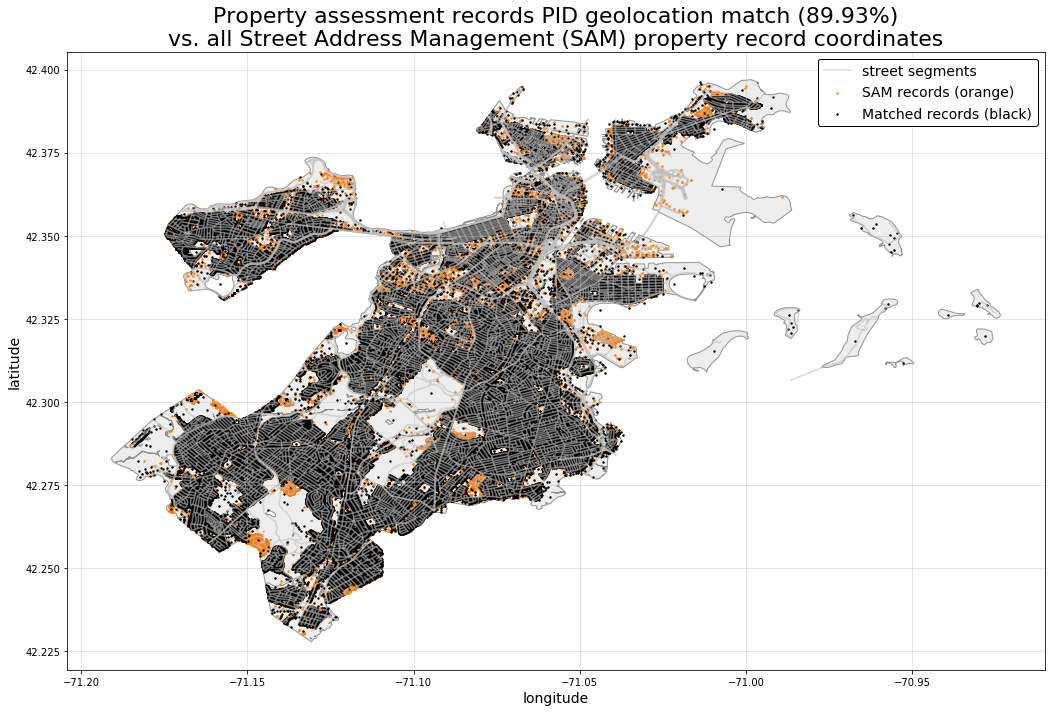

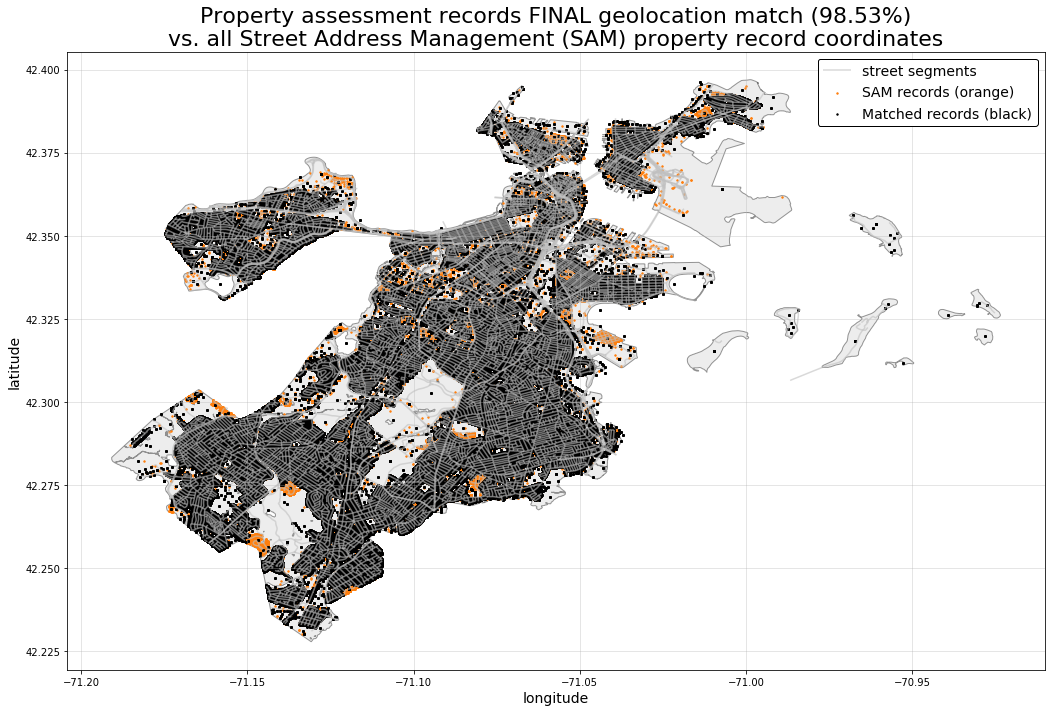

CPU times: user 28.9 s, sys: 507 ms, total: 29.4 s
Wall time: 28.8 s


In [33]:
%%time

# set parameter whether or not to save these two plots
savefig = True

# Plot PID coordinates from consolidated property dataset over top
# of SAM addresses master list to identify what areas are missing and
# potential sources of bias in our data

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records PID geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(PID_matchrate),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    PID_coord_match_key['LONGITUDE'].dropna(), PID_coord_match_key['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'match-PID-only.png'))
plt.show();

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records FINAL geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(matchrate_final),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    prop_df['LONGITUDE'].dropna(), prop_df['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'match-FINAL.png'))
plt.show();

In [34]:
# plot missing records by zip to identify hot spots

# generate missing record and st_zip_match records to plot as choropleth
matched_records_by_zip = prop_df.loc[~prop_df['LATITUDE'].isnull()].loc[
    prop_df['st_zip_match']==0
].groupby('ZIPCODE').agg({'PID': 'count'})['PID']

missing_records_by_zip = prop_df.loc[
    (prop_df['LATITUDE'].isnull()) | (prop_df['st_zip_match']==1)
].groupby('ZIPCODE').agg({'PID': 'count'})['PID']

st_zip_match_records_by_zip = prop_df.loc[prop_df['st_zip_match']==1]['ZIPCODE'].value_counts()

concat_missing_and_not = pd.concat([missing_records_by_zip, matched_records_by_zip], axis=1, sort=True)
missing_ratio_by_zip = concat_missing_and_not.iloc[:, 0].fillna(0) / concat_missing_and_not.sum(axis=1)

missing_records_by_zip.name = 'missing_records'
st_zip_match_records_by_zip.name = 'st_zip_match'
missing_ratio_by_zip.name = 'ratio_missing_to_matched' 

# To lebel zipcodes, find a "representative point" for each polygon geometry
gdf_zips['coords'] = gdf_zips['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_zips['coords'] = [coords[0] for coords in gdf_zips['coords']]

# make new version of gdf_zips for plotting choropleths
gdf_zips_match = gdf_zips.join(
    missing_records_by_zip, on='ZIP5'
).join(
    st_zip_match_records_by_zip, on='ZIP5'
).join(
    missing_ratio_by_zip, on='ZIP5'
)

In [65]:
# define function for plotting choropleth for quick check of record distributions
# across shapes by shapetype

def make_choropleth(gdf, variable, title, cb_label, cmap='Blues',
                    labels=None, savepath=None, citybounds=True):
    """
    plots choropleth
    
    gdf: the geopandas dataframe object containing the polygons and corresponding variable
         of interest
    variable: str, the column name for the variable of interest
    title: str, the title of the plot
    cb_label: str, the label for the colorbar
    cmap: str, the matplotlib predefined colormap colorscheme to use
    labels: string, will plot shape label if True. However coordinates for desired
            shapelabels need to stored in gdf in a column titled 'coords'
    savepath: None or str, filepath to which the plot should be saved. If None, the plot
              is not written to disk
    citybounds: boolean, if True, the city boundary for Boston is overlaid on the plot
    """
    # Now to add a colorbar for better interpretability of our choropleth plot

    # set min and max variable values for use in plotting our colorbar
    vmin = gdf[variable].describe()['min']
    vmax = gdf[variable].describe()['max']

    fig, ax = plt.subplots(figsize=(16,10))

    plt.title(
        title,
        fontsize=22
    )

    # NOTE: null values must be dropped from our df (as is shown below).
    #       Otherwise, the choropleth does not provide any gradation in color
    gdf.dropna(subset=[variable]).plot(
        column=variable,
        cmap=cmap,
        linewidth=1,
        ax=ax,
        edgecolor='k'
    )
    
    if citybounds:
        gdf_boston.plot(ax=ax, facecolor="none", edgecolor='k', alpha=0.4)

    # here we use the geopandas dataframe object's built-in iterrows() method
    # to turn zipshape_df into a generator object for iteration
    if labels:
        for idx, row in gdf.iterrows():
            plt.annotate(
                s=row[labels],
                xy=row['coords'],
                horizontalalignment='center',
                verticalalignment='center',
                weight='bold'
            )

    # here we create a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # ...then we add the colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, shrink=.8, fraction=0.1)

    # ...and finally we format the colorbar for readability
    cbar.set_label(label='\n{}'.format(cb_label), fontsize=18)
    cbar.ax.tick_params(labelsize=14)

    plt.xlabel('longitude', fontsize=14)
    plt.ylabel('latitude', fontsize=14)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

    # save figure if savepath is entered
    if savepath:
        plt.savefig(savepath)
    plt.show();

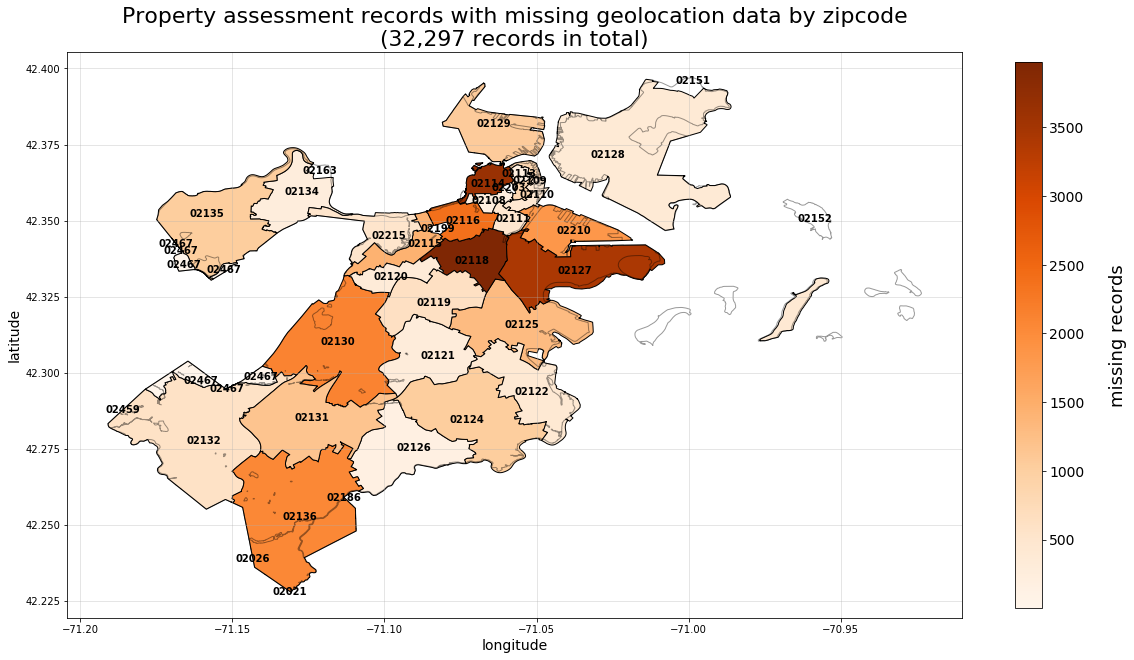

In [66]:
variable = 'missing_records'
cb_label = 'missing records'
title = 'Property assessment records with missing geolocation data by zipcode\n'\
        '({0:,} records in total)'.format(sum(missing_records_by_zip))
savepath = os.path.join(FIGURES_ROOT, 'match-missing-by-zip.png')

make_choropleth(gdf_zips_match, variable, title,
                cb_label, cmap='Oranges', labels='ZIP5', savepath=savepath)

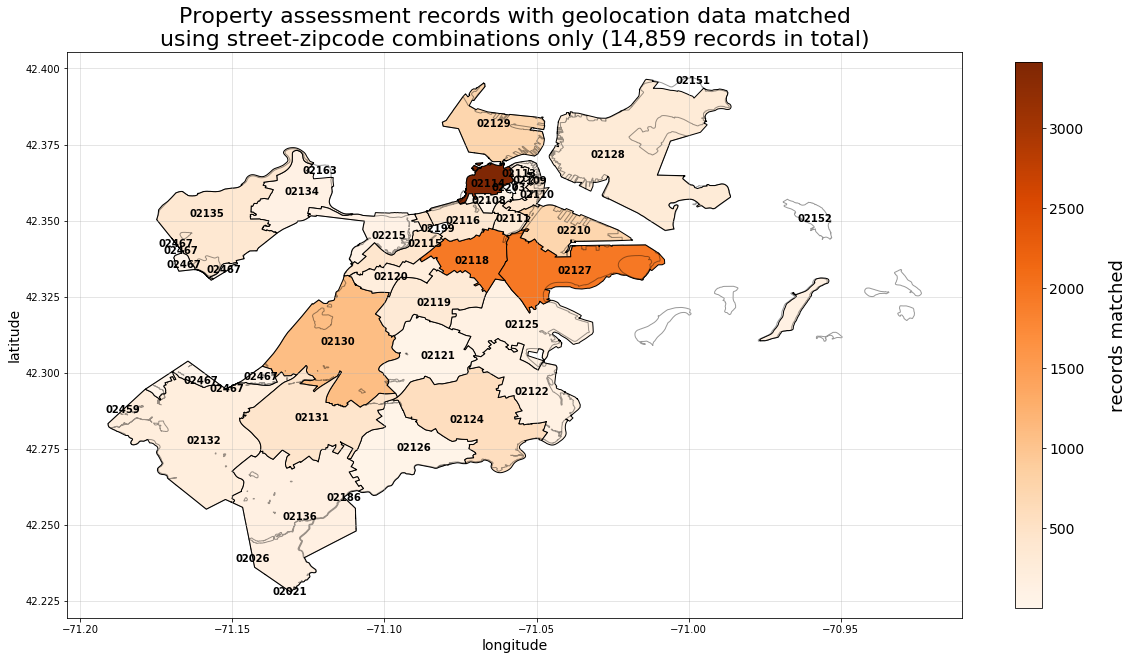

In [67]:
variable = 'st_zip_match'
cb_label = 'records matched'
title = 'Property assessment records with geolocation data matched\nusing '\
        'street-zipcode combinations only ({0:,} records in total)'.format(
    sum(st_zip_match_records_by_zip)
)
savepath = os.path.join(FIGURES_ROOT, 'match-street-zip-only.png')

make_choropleth(gdf_zips_match, variable, title, cb_label,
                cmap='Oranges', labels='ZIP5', savepath=savepath)

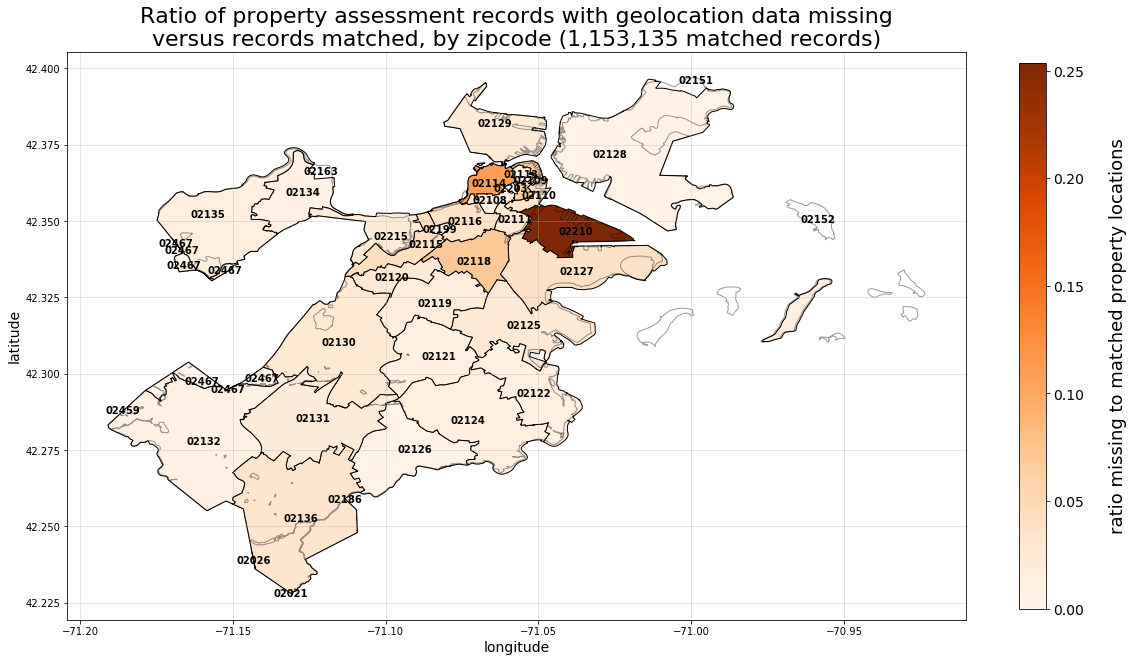

In [68]:
variable = 'ratio_missing_to_matched'
cb_label = 'ratio missing to matched property locations'
title = 'Ratio of property assessment records with geolocation data missing\n'\
        'versus records matched, by zipcode ({0:,} matched records)'.format(
    sum(matched_records_by_zip)
)
savepath = os.path.join(FIGURES_ROOT, 'match-ratio-missing-by-zip.png')

make_choropleth(gdf_zips_match, variable, title, cb_label,
                cmap='Oranges', labels='ZIP5', savepath=savepath)

## Subset property data to include only records with location data and finish cleansing / enriching data

In [39]:
########################################################
## ELIMINATE RECORDS WITH NO LOCATION DATA
#######################################################

print(
    'The shape of the dataset prior to subsetting is:\n\n\t{}\n'.format(prop_df.shape)
)

prop_df = prop_df.loc[~prop_df['LATITUDE'].isnull()].loc[prop_df['st_zip_match']==0].copy()

print(
    'The shape of the dataset after removing records with no location '\
    'coordinates is:\n\n\t{}\n'.format(prop_df.shape)
)

The shape of the dataset prior to subsetting is:

	(1185432, 84)

The shape of the dataset after removing records with no location coordinates is:

	(1153135, 84)



In [102]:
prop_df['AV_TOTAL'] = prop_df['AV_TOTAL'].astype(int)

In [40]:
prop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153135 entries, 0 to 1153134
Data columns (total 84 columns):
PID                1153135 non-null object
CM_ID              501449 non-null object
GIS_ID             664804 non-null object
ST_NUM             1153135 non-null object
ST_NAME            1153135 non-null object
ST_NAME_SUF        1153135 non-null object
UNIT_NUM           420343 non-null object
ZIPCODE            1153135 non-null object
PTYPE              1153132 non-null object
LU                 1153135 non-null object
OWN_OCC            1153114 non-null object
OWNER              1153135 non-null object
MAIL_ADDRESSEE     588008 non-null object
MAIL_ADDRESS       1153135 non-null object
MAIL CS            1153135 non-null object
MAIL_ZIPCODE       1153133 non-null object
AV_LAND            1153134 non-null object
AV_BLDG            1153135 non-null object
AV_TOTAL           1153135 non-null object
GROSS_TAX          1153135 non-null object
LAND_SF            1141649 non-

## Label each record with corresponding shapefile polygon data based on record coordinates

In [41]:
# Define functions for converting dataframes to geodataframes, for matching polygons,
# and for merging match data back into original dataframe

def make_gdf_geometries(df_data, lon_col, lat_col, gdf_cols):
    """
    """
    # create geoseries of coordinate points for all records
    gs_points = gpd.GeoSeries(
        map(Point, zip(df_data[lon_col].values, df_data[lat_col].values))
    )

    # define our crs parameter for our coordinate reference system
    crs = {'init': 'epsg:4326'}

    # create a new geodataframe using df_sam as the base, define crs, and add in our point
    # geometries.
    gdf_data = gpd.GeoDataFrame(
        df_data[gdf_cols].reset_index(),
        crs=crs, geometry=gs_points
    )
    
    return gdf_data

    
def make_shapematch_gdf(gdf_data, gdf_shape, shapesname, no_copy_cols='geometry'):
    """
    """    
    # make column name list for modifying merged names
    colnames = ['index_right']
    colnames.extend([
        colname for colname in gdf_shape.columns
        if colname not in no_copy_cols
    ])
    colnames_shape = [
        '{0}_{1}'.format(colname, shapesname)
        for colname in colnames
    ]
    len_colnames = len(colnames)

    # make certain we have a matching coordiate reference systems
    # assigned to our new GeoDataFrame and shapefile
    gdf_data.crs = gdf_shape.crs

    # then joing our two GeoDataFrames
    gdf_joined = gpd.sjoin(gdf_data, gdf_shape, how='left',op="within")
    
    gdf_joined = gdf_joined.rename(
        columns=dict(zip(colnames, colnames_shape))
    )
    
    return gdf_joined, colnames_shape

def merge_shapematch_df(df_data, gdf_joined, merge_cols):
    """
    """
    df_copy = df_data
    # add specified merge_cols to dataframe
    df_copy[merge_cols] = gdf_joined[merge_cols].copy()
    
    return df_copy
    

In [45]:
%%time

#######################################################################
# MATCH SHAPES FOR ALL RECORDS WITH COORDINATES AND APPEND TO DATAFRAME
#######################################################################

# create disctionary of shape files for matching
shape_gdfs_dict = {
    'neighborhood': gdf_hoods,
    'censustract': gdf_tracts,
}

# create crime geodataframe
gdf_prop = make_gdf_geometries(prop_df, 'LONGITUDE', 'LATITUDE', ['PID', 'fiscal-year'])

# append df_crime with new shape columns for each shapefile
for i, (key, gdf) in enumerate(shape_gdfs_dict.items()):
    prop_df = merge_shapematch_df(
        prop_df,
        *make_shapematch_gdf(gdf_prop, gdf, shapesname=key)
    )

CPU times: user 1min 19s, sys: 1.9 s, total: 1min 21s
Wall time: 1min 8s


In [55]:
# inspect results
print(prop_df.iloc[:,:10].info())
print()
print(prop_df.iloc[:,-29:].info())
prop_df.iloc[:,-25:].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153135 entries, 0 to 1153134
Data columns (total 10 columns):
PID            1153135 non-null object
CM_ID          501449 non-null object
GIS_ID         664804 non-null object
ST_NUM         1153135 non-null object
ST_NAME        1153135 non-null object
ST_NAME_SUF    1153135 non-null object
UNIT_NUM       420343 non-null object
ZIPCODE        1153135 non-null object
PTYPE          1153132 non-null object
LU             1153135 non-null object
dtypes: object(10)
memory usage: 96.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153135 entries, 0 to 1153134
Data columns (total 29 columns):
is_prop                     1153135 non-null int64
st_zip_match                1153135 non-null int64
index_right_neighborhood    1152130 non-null float64
OBJECTID_neighborhood       1152130 non-null float64
Name_neighborhood           1152130 non-null object
Acres_neighborhood          1152130 non-null float64
Neighborho_neighborhood   

,Name_neighborhood,Acres_neighborhood,Neighborho_neighborhood,SqMiles_neighborhood,ShapeSTAre_neighborhood,ShapeSTLen_neighborhood,index_right_censustract,FID_censustract,OBJECTID_censustract,STATEFP10_censustract,...,MTFCC10_censustract,FUNCSTAT10_censustract,ALAND10_censustract,AWATER10_censustract,INTPTLAT10_censustract,INTPTLON10_censustract,Shape_STAr_censustract,Shape_STLe_censustract,Shape__Are_censustract,Shape__Len_censustract
0,Beacon Hill,200.156904,30,0.31,8.718800e+06,14303.829017,177.0,178.0,178.0,25,...,G5020,S,223142.0,0.0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,408899.925781,3149.451618
1,Beacon Hill,200.156904,30,0.31,8.718800e+06,14303.829017,177.0,178.0,178.0,25,...,G5020,S,223142.0,0.0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,408899.925781,3149.451618
2,Beacon Hill,200.156904,30,0.31,8.718800e+06,14303.829017,177.0,178.0,178.0,25,...,G5020,S,223142.0,0.0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,408899.925781,3149.451618
3,Beacon Hill,200.156904,30,0.31,8.718800e+06,14303.829017,177.0,178.0,178.0,25,...,G5020,S,223142.0,0.0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,408899.925781,3149.451618
4,Beacon Hill,200.156904,30,0.31,8.718800e+06,14303.829017,177.0,178.0,178.0,25,...,G5020,S,223142.0,0.0,+42.3577086,-071.0694112,2.401693e+06,7637.223404,408899.925781,3149.451618


In [79]:
# Prepare data for plotting property record choropleths

# set a few parameters for preparing data
shapedim_list = ['ZIPCODE', 'Name_neighborhood', 'TRACTCE10_censustract']
joincol_list = ['ZIP5', 'Name', 'TRACTCE10']
shapetype_list = ['zipcode', 'neighborhood', 'census tract']

# create groupby counts for each shape of interest
prop_by_shape_list = [
    prop_df.groupby(shapedim).agg({
        'PID': 'count'
    }).rename({'PID': 'property records'}, axis=1)
    for shapedim in shapedim_list
]

# label each shape in shapefile with shapename at representative coordinate
for gdf in [gdf_zips, gdf_hoods, gdf_tracts]:
    gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf['coords'] = [coords[0] for coords in gdf['coords']]

# create joins with shapefiles to append with groupy counts for plotting
gdf_by_shape_dict = {
    shapetype: gdf.join(prop_by_shape, on=joincol)
    for shapetype, gdf, prop_by_shape, joincol in zip(
        shapetype_list,
        [gdf_zips.copy(), gdf_hoods.copy(), gdf_tracts.copy()],
        prop_by_shape_list,
        joincol_list
    )
}

# drop census tract that goes waaaay out off shore into the ocean
gdf_by_shape_dict['census tract'] = gdf_by_shape_dict['census tract'].loc[
    gdf_by_shape_dict['census tract']['TRACTCE10']!='990101'
]

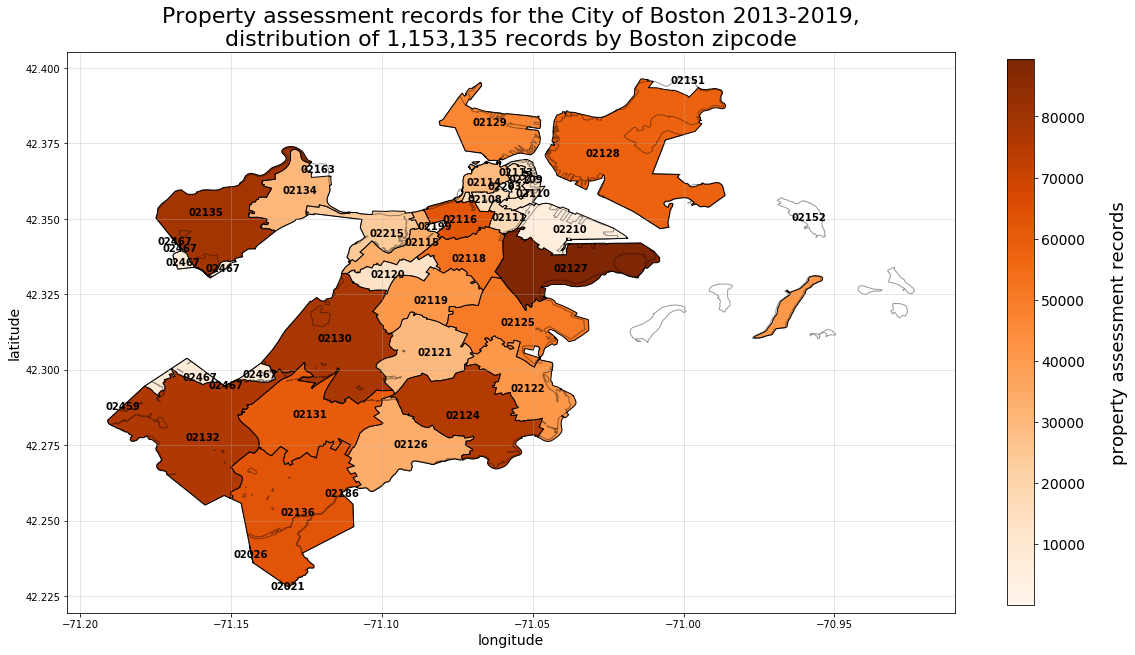

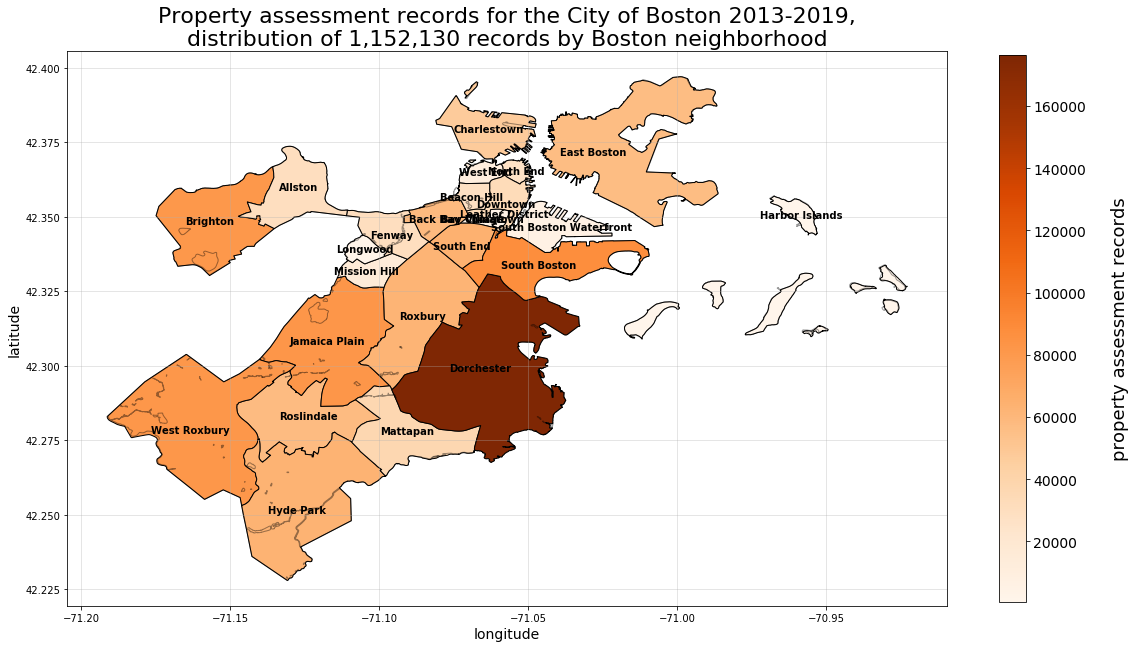

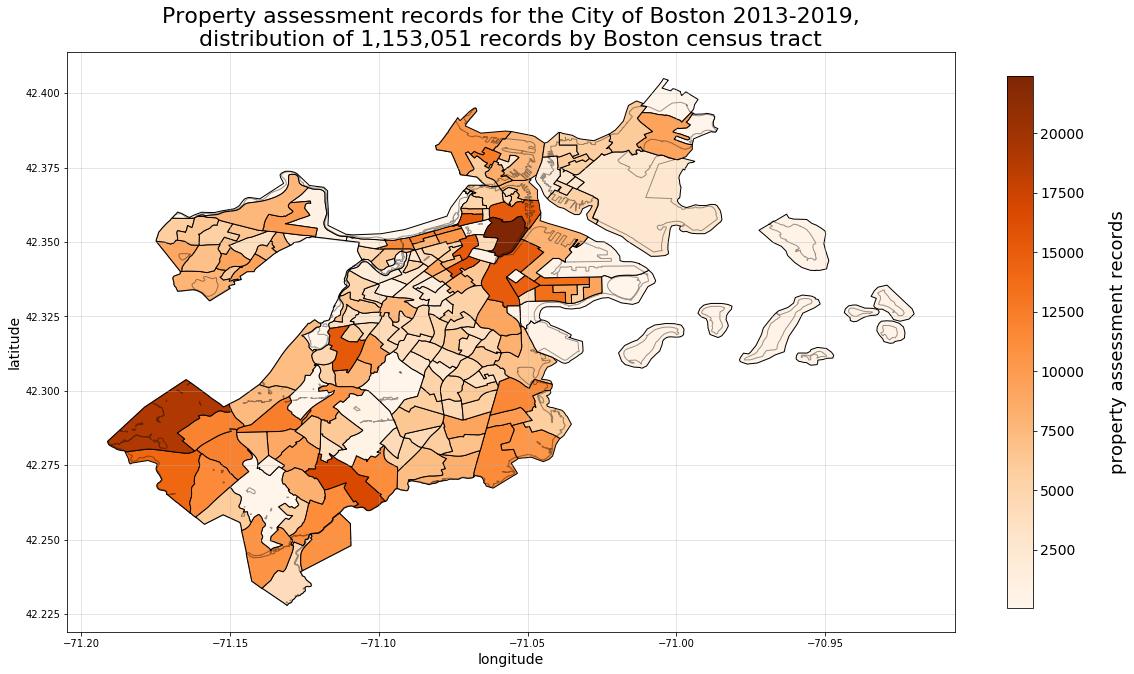

In [81]:
# Plot and save choropleths

fiscal_years = list(set(prop_df['fiscal-year']))
fiscal_years.sort()

# only label zipcodes and neighborhood, but not census tracts beacuse too small
labels_list = [joincol_list[0], joincol_list[1], None]

# set chart titles
titles_list = [
    'Property assessment records for the City of Boston {0}-{1},\n'\
    'distribution of {2:,} records by Boston {3}'.format(
        min(fiscal_years),
        max(fiscal_years),
        prop_by_shape.sum()[0],
        shapetype
    ) for shapetype, prop_by_shape in zip(
        shapetype_list, prop_by_shape_list
    )
]

# set savepaths
savepaths_list = [
    os.path.join(FIGURES_ROOT, 'property-records-by-{}.png'.format(shapetype))
    for shapetype in shapetype_list
]

for gdf, labels, title, savepath in zip(
    gdf_by_shape_dict.values(), labels_list, titles_list, savepaths_list
):
    make_choropleth(
        gdf, variable='property records', title=title, cb_label='property assessment records',
        cmap='Oranges', labels=labels, savepath=savepath, citybounds=True
    )

In [135]:
###################################################
## LABEL RECORDS TO IDENTIFY RESIDENTIAL PROPERTIES
###################################################

residential_lus = ['CD', 'R1', 'R2', 'R3', 'R4']
residential_ptypes = list(np.arange(101,111).astype(str))

prop_df['res_lu'] = prop_df['LU'].isin(residential_lus).astype(int)
prop_df['res_ptype'] = prop_df['PTYPE'].isin(residential_ptypes).astype(int)

In [316]:
def make_quantile_by_df(df_data, groupby_col, variable, years_col,
                        subset_loc=None, years_list=None, quantile=0.5):
    """
    Makes dataframe of values by specified quantile for each set of
    properties defined by the groupby_col
    
    df_data: DataFrame, of the input data you are calculating
    groupby_col: str, the name of column containing values on which
                 you are grouping records
    variable: str, the name of column containing the quantitative
              variable on which you are performing quantile calculations
    subset_loc: list or array of booleans, or None, specifying the indices on
                which you are subsetting the records (enter None
                if you do not wish to subset and all rows will be calculated)
    years_col: str, the name of the column containing year values
    year_list: list or None, the list of year values you wish to report in
               the final dataframe, if None all available years are used 
    quantile: flot, default=0.5, the quantile you wish to calculate
    
    returns: DataFrame of final summary data
    """
    if type(subset_loc) == type(None):
        subset_loc = np.full(len(df_data), True, dtype=bool)
    if type(years_list) == type(None):
        years_list = list(set(df_data[years_col].values))
        years_list.sort()
    
    by_list = [
        df_data.loc[
            (residential_loc) &
            (df_data[years_col]==year)
        ].groupby(groupby_col)[variable].quantile(.5)
        for year in years_list
    ]

    by_df = pd.concat(by_list, axis=1, sort=True)
    by_df.columns = np.array(years_list).astype(int)
    
    return by_df


def make_cagr_by_df(groupby_df, n_years):
    """
    Makes dataframe of values calculating n years compound annual
    growth rate (CAGR) by year and row for all years with sufficient
    prior year values
    
    groupby_df: dataframe of values wherein each row is a group, each
                column is a year, and the values represent the values
                for which you wish to calculate growth
    n_years: int, number of years to calculate inclusive to each CARG,
             cannot exceed the number of years available in groupby_df
    
    returns: dataframe of calculated CAGR values by year and row
    """
    groupby_df.columns = groupby_df.columns.astype(int)
    year_list = groupby_df.columns
    min_year = min(year_list)
    max_year = max(year_list)
    
    calc_years = np.arange(min_year+n_years, max_year+1)
    
    cagr_df = pd.DataFrame(
        np.hstack([
            (np.power(
                groupby_df[year].values / groupby_df[year-n_years].values,
                1/n_years
            ) - 1).reshape(-1,1)
            for year in calc_years
        ]),
        index=groupby_df.index,
        columns=calc_years
    )
    
    return cagr_df


def gini_coef(values):
    """
    calculates an unweighted gini coefficient for a set of input values
    
    values: 1d array, list, or pd.Series containing the values for which
            to calculate the gini coefficient
    
    returns: float, calculated gini coefficient
    """
    values = np.asarray(values)
    sorted_vals = np.sort(values)
    n_vals = len(values)
    cumsum_vals = np.cumsum(sorted_vals, dtype=float)
    return (
        (n_vals + 1 - 2 * np.sum(cumsum_vals) / cumsum_vals[-1]) / n_vals
    )


def make_gini_by_df(df_data, groupby_col, variable, years_col,
                    subset_loc=None, years_list=None):
    """
    Makes dataframe of gini coefficient values for each set of
    properties defined by the groupby_col by year
    
    df_data: DataFrame, of the input data you are calculating
    groupby_col: str, the name of column containing values on which
                 you are grouping records
    variable: str, the name of column containing the quantitative
              variable on which you are performing gini coef calculations
    subset_loc: list or array of booleans, or None, specifying the indices on
                which you are subsetting the records (enter None
                if you do not wish to subset and all rows will be calculated)
    years_col: str, the name of the column containing year values
    year_list: list or None, the list of year values you wish to report in
               the final dataframe, if None all available years are used 
    
    returns: DataFrame of final summary data
    """
    if type(subset_loc) == type(None):
        subset_loc = np.full(len(df_data), True, dtype=bool)
    if type(years_list) == type(None):
        years_list = list(set(df_data[years_col].values))
        years_list.sort()
    
    by_list = [
        df_data.loc[
            (residential_loc) &
            (df_data[years_col]==year)
        ].groupby(groupby_col)[variable].apply(lambda x: gini_coef(x))
        for year in years_list
    ]

    by_df = pd.concat(by_list, axis=1, sort=True)
    by_df.columns = np.array(years_list).astype(int)
    
    return by_df  

In [315]:
make_gini_by_df(
    df_data=prop_df,
    groupby_col='Name_neighborhood',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
)

,2013,2014,2015,2016,2017,2018,2019
Name_neighborhood,,,,,,,
Allston,0.272307,0.277313,0.290890,0.306969,0.315580,0.311445,0.308468
Back Bay,0.473026,0.476730,0.476981,0.489140,0.489416,0.494004,0.491832
Bay Village,0.275816,0.277074,0.287866,0.299172,0.307525,0.309708,0.313278
Beacon Hill,0.485934,0.487534,0.487315,0.488553,0.486952,0.490860,0.499971
Brighton,0.285847,0.285203,0.313949,0.327241,0.329230,0.321427,0.317287
Charlestown,0.264974,0.267300,0.271644,0.279342,0.285215,0.289514,0.290207
Chinatown,0.228957,0.231251,0.237185,0.243283,0.244830,0.250371,0.244452
Dorchester,0.178833,0.182098,0.185743,0.194527,0.198709,0.199269,0.201539
Downtown,0.375843,0.380512,0.402960,0.405804,0.419432,0.469259,0.467327


In [310]:
x = prop_df.loc[residential_loc].loc[prop_df['fiscal-year']=='2018'].loc[prop_df['Name_neighborhood']=='Roxbury']['AV_TOTAL'].values

gini_coef(x)

0.23544022759192446

In [311]:
prop_df.loc[residential_loc].loc[prop_df['fiscal-year']=='2018'].groupby('Name_neighborhood')['AV_TOTAL'].apply(lambda x: gini_coef(x))

TypeError: 'numpy.float64' object is not callable

In [304]:
prop_df.loc[residential_loc].loc[prop_df['fiscal-year']=='2018'].groupby('Name_neighborhood')['AV_TOTAL'].apply(lambda x: np.sum(x))

Name_neighborhood
Allston                    1677868719
Back Bay                   8309400757
Bay Village                 287117578
Beacon Hill                3782971297
Brighton                   5345320146
Charlestown                3466009658
Chinatown                   101512485
Dorchester                 8138951414
Downtown                   4989812626
East Boston                2628731694
Fenway                     1369982067
Hyde Park                  2701209128
Jamaica Plain              5230171393
Leather District            283244610
Longwood                     49236372
Mattapan                   1499771207
Mission Hill                961017727
North End                  1894401934
Roslindale                 3013600905
Roxbury                    1949707214
South Boston               5880020000
South Boston Waterfront     406075720
South End                  6434767687
West End                    558662600
West Roxbury               4401417776
Name: AV_TOTAL, dtype: int64

In [303]:
prop_df.loc[residential_loc].loc[prop_df['fiscal-year']=='2018'].groupby('Name_neighborhood')['AV_TOTAL'].sum()

Name_neighborhood
Allston                    1677868719
Back Bay                   8309400757
Bay Village                 287117578
Beacon Hill                3782971297
Brighton                   5345320146
Charlestown                3466009658
Chinatown                   101512485
Dorchester                 8138951414
Downtown                   4989812626
East Boston                2628731694
Fenway                     1369982067
Hyde Park                  2701209128
Jamaica Plain              5230171393
Leather District            283244610
Longwood                     49236372
Mattapan                   1499771207
Mission Hill                961017727
North End                  1894401934
Roslindale                 3013600905
Roxbury                    1949707214
South Boston               5880020000
South Boston Waterfront     406075720
South End                  6434767687
West End                    558662600
West Roxbury               4401417776
Name: AV_TOTAL, dtype: int64

In [291]:
x = prop_df.loc[residential_loc].loc[prop_df['fiscal-year']=='2018'].loc[prop_df['Name_neighborhood']=='Roxbury']['AV_TOTAL'].values
sorted_x = np.sort(x)
n = len(x)
cumx = np.cumsum(sorted_x, dtype=float)
# The above formula, with all weights equal to 1 simplifies to:
(n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

0.23544022759192446

In [287]:
%%time

# calculate median residential property values by shape
residential_loc = prop_df['res_ptype']==1
variable = 'AV_TOTAL'
years_col = 'fiscal-year'
quantile = 0.5

median_by_zip_df = make_quantile_by_df(
    df_data=prop_df,
    groupby_col='ZIPCODE',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
    quantile=quantile
)

median_by_hood_df = make_quantile_by_df(
    df_data=prop_df,
    groupby_col='Name_neighborhood',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
    quantile=quantile
)

median_by_tract_df = make_quantile_by_df(
    df_data=prop_df,
    groupby_col='TRACTCE10_censustract',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
    quantile=quantile
)

# calculate growth rate for median values by shape
n_years=3

cagr_by_zip_df = make_cagr_by_df(
    groupby_df=median_by_zip_df,
    n_years=n_years
)

cagr_by_hood_df = make_cagr_by_df(
    groupby_df=median_by_hood_df,
    n_years=n_years
)

cagr_by_tract_df = make_cagr_by_df(
    groupby_df=median_by_tract_df,
    n_years=n_years
)

CPU times: user 3.81 s, sys: 468 ms, total: 4.27 s
Wall time: 4.27 s


In [ ]:
%%time

# calculate gini coefficient by shape
residential_loc = prop_df['res_ptype']==1
variable = 'AV_TOTAL'
years_col = 'fiscal-year'
quantile = 0.5

median_by_zip_df = make_quantile_by_df(
    df_data=prop_df,
    groupby_col='ZIPCODE',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
    quantile=quantile
)

median_by_hood_df = make_quantile_by_df(
    df_data=prop_df,
    groupby_col='Name_neighborhood',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
    quantile=quantile
)

median_by_tract_df = make_quantile_by_df(
    df_data=prop_df,
    groupby_col='TRACTCE10_censustract',
    variable=variable,
    years_col=years_col,
    subset_loc=residential_loc,
    quantile=quantile
)

# calculate growth rate for gini coefficients by shape
n_years=3

cagr_by_zip_df = make_cagr_by_df(
    groupby_df=median_by_zip_df,
    n_years=n_years
)

cagr_by_hood_df = make_cagr_by_df(
    groupby_df=median_by_hood_df,
    n_years=n_years
)

cagr_by_tract_df = make_cagr_by_df(
    groupby_df=median_by_tract_df,
    n_years=n_years
)

In [288]:
cagr_by_hood_df

,2016,2017,2018,2019
Name_neighborhood,,,,
Allston,0.070605,0.085323,0.078357,0.072984
Back Bay,0.073734,0.081816,0.057281,0.056204
Bay Village,0.106066,0.107590,0.090422,0.062189
Beacon Hill,0.075402,0.068769,0.055217,0.050813
Brighton,0.082294,0.093571,0.070935,0.069109
Charlestown,0.105923,0.109777,0.082429,0.053423
Chinatown,0.103444,0.097533,0.089315,0.043827
Dorchester,0.110049,0.127019,0.107589,0.076419
Downtown,0.070749,0.058045,0.058887,0.025399


In [110]:
prop_df['LU'].value_counts(dropna=False)

CD                       409156
R1                       214289
R2                       121731
R3                        98649
CM                        64194
E                         59085
RL                        48202
C                         30514
A                         20228
RC                        18777
R4                        17804
CP                        17267
CL                        14638
CC                        11277
EA                         4113
I                          3183
AH                           21
XX                            3
995                           1
13                            1
144 Beacon St # 2 3 &         1
102                           1
Name: LU, dtype: int64

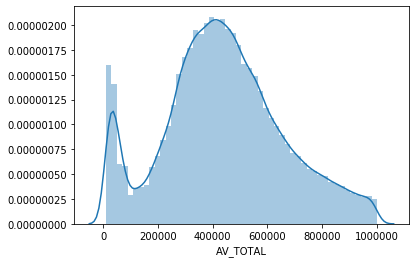

In [109]:
sns.distplot(prop_df['AV_TOTAL'].loc[prop_df['fiscal-year']=='2018'].loc[prop_df['AV_TOTAL']>10000].loc[prop_df['AV_TOTAL']<1000000])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2cb0191210>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2cb01a3850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2cb019a250>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2cb01a92d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2cb01a97d0>],
 'means': []}

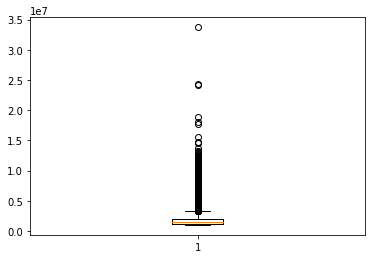

In [144]:
plt.boxplot(prop_df['AV_TOTAL'].loc[prop_df['res_ptype']==1].loc[prop_df['fiscal-year']=='2018'].loc[prop_df['AV_TOTAL']>1000000])

In [152]:
for year in fiscal_years:
    print(
        '{:,}'.format(
            int(prop_df.loc[
                (prop_df['res_ptype']==1) &
                (prop_df['fiscal-year']==year)
            ]['AV_TOTAL'].mean())
        )
    )
    
print()
for year in fiscal_years:
    print(
        '{:,}'.format(
            int(prop_df.loc[
                (prop_df['res_ptype']==1) &
                (prop_df['fiscal-year']==year)
            ]['AV_TOTAL'].quantile(.5))
        )
    )

400,840
420,550
463,503
526,081
565,683
599,893
637,204

316,907
329,700
362,500
413,200
445,000
468,500
502,700


In [153]:
for year in fiscal_years:
    print(
        '{:,}'.format(
            int(prop_df.loc[
                (prop_df['res_lu']==1) &
                (prop_df['fiscal-year']==year)
            ]['AV_TOTAL'].mean())
        )
    )
    
print()
for year in fiscal_years:
    print(
        '{:,}'.format(
            int(prop_df.loc[
                (prop_df['res_lu']==1) &
                (prop_df['fiscal-year']==year)
            ]['AV_TOTAL'].quantile(.5))
        )
    )

415,626
436,587
483,569
549,356
592,341
629,848
669,997

323,400
336,684
371,500
423,700
457,100
481,900
517,900


In [137]:
prop_df.loc[prop_df['res_lu']==1]['AV_TOTAL'].describe()

count    8.616290e+05
mean     5.402752e+05
std      5.483260e+05
min      0.000000e+00
25%      2.998000e+05
50%      4.130000e+05
75%      5.876000e+05
max      3.700000e+07
Name: AV_TOTAL, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2cb082e650>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2cb0833690>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2cb082e3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2cb07d1250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2cb07d1750>],
 'means': []}

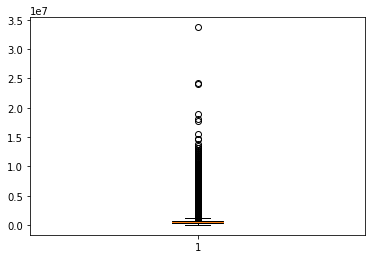

In [131]:
plt.boxplot(prop_df.loc[prop_df['residential_lu']==1].loc[prop_df['fiscal-year']=='2018']['AV_TOTAL'])

In [145]:
prop_df.loc[prop_df['res_ptype']==1].loc[prop_df['fiscal-year']=='2018']['AV_TOTAL'].value_counts().sort_index()

3400         1
5500        12
5900         1
6100        11
6200         1
6300         1
6400         1
6500         3
7300         1
7500        25
7900         1
8000         1
8100         2
8600         1
9000        88
9200         1
9300         1
10000       10
10100        1
10300        1
10500       15
10700        1
10800        2
10900        1
11000        9
11100        1
11200        1
11400        2
11500        1
11600        3
            ..
11154875     1
11294528     1
11332300     1
11336000     1
11393600     1
11412500     1
11639000     1
11766000     1
11994570     1
12042800     1
12152800     1
12170200     1
12351200     1
12420500     1
12656100     1
12737700     1
12843200     1
13079600     1
13162500     1
13209200     1
13746071     1
14641600     1
14680000     1
15586100     1
17764800     1
18039500     1
18900000     1
24095000     1
24250500     1
33727536     1
Name: AV_TOTAL, Length: 19001, dtype: int64

In [130]:
prop_df.loc[prop_df['residential_lu']==1].loc[prop_df['fiscal-year']=='2018']['AV_TOTAL'].value_counts().sort_index()

10000       10
10500        3
12600        1
30100        1
39700        9
40300       41
44600        1
46300        5
47000       13
61300        1
62400        1
63800        1
64900        1
68183        1
69500        6
70200        1
70500        1
70800        1
72300        2
72600        1
72900        1
73500        1
73700        1
74400        1
75800        1
76700        1
77200        1
78300        1
78320        1
78699        2
            ..
11294528     1
11332300     1
11336000     1
11393600     1
11412500     1
11639000     1
11766000     1
11994570     1
12042800     1
12152800     1
12170200     1
12351200     1
12420500     1
12656100     1
12737700     1
12843200     1
13079600     1
13162500     1
13209200     1
13450000     1
13746071     1
14641600     1
14680000     1
15586100     1
17764800     1
18039500     1
18900000     1
24095000     1
24250500     1
33727536     1
Name: AV_TOTAL, Length: 19012, dtype: int64

In [138]:
prop_df['YR_BUILT'].value_counts(dropna=False)

0         123617
1900      119731
1920       84134
1910       80310
1905       71483
1899       67668
1890       61628
1930       29325
1999       28240
1925       25641
1880       23006
1950       22783
1960       16755
1935       15644
2006       15495
1915       14299
1940       12865
NaN        11764
1989       11247
1885       10567
1965        9679
2004        9511
1875        9183
2000        9056
1988        8620
1955        8089
1964        7699
1987        6936
2002        6935
1870        6374
           ...  
1814           8
1775           7
1710           7
1807           7
1779           7
1808           7
1802           7
1792           7
1760           7
1803           7
1823           7
1791           7
1700           7
1819           7
1804           7
1806           6
640            2
2019           2
867            2
324561         2
794            1
1553           1
62986          1
3802           1
773            1
7950           1
2829           1
29074         

In [74]:
lu_drop_list = [
    '102', '144 Beacon St # 2 3 &', '357', '995', '13', np.nan
]
prop_df = prop_df.loc[~prop_df['LU'].isin(lu_drop_list)]

In [99]:
#### SHIFT VALUES LEFT
prop_df.loc[prop_df['AV_LAND'].str.contains('_')].iloc[:,12:32]

,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,STRUCTURE_CLASS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS
1146003,NaN,11 WALNUT HILL RD,BROOKLINE MA,NaN,02146_,0,135700,135700,1707,867,1930,1983,867,867,1,NaN,NaN,NaN,NaN,0
1146004,NaN,11 WALNUT HILL RD,BROOKLINE MA,NaN,02146_,0,123200,123200,1549,640,1899,1987,640,640,1,NaN,NaN,NaN,NaN,0


In [139]:
prop_df['YR_REMOD'].value_counts(dropna=False)

0       370851
NaN     213448
1999     40490
1985     32924
2005     29416
1980     27417
2004     24402
2006     22868
2002     21545
2003     19619
1986     19020
2000     17773
1984     17414
2001     16215
1983     15291
1987     14629
2008     13500
2009     13280
2012     12709
2007     12579
2010     12051
2011     12018
1982     11770
1997     11498
2013     10392
1989      9470
2015      9275
1981      8727
1996      8476
1990      8330
         ...  
1933        21
1927        19
1928        15
1902        14
1914        14
1910        14
1951        14
1939        11
1923        10
1934         9
1915         8
1942         7
1946         7
1937         7
1904         7
1921         7
1919         7
1929         7
1948         7
1878         7
1941         7
1932         5
995          5
1828         4
1893         4
1899         4
1917         4
1944         3
2019         2
2710         1
Name: YR_REMOD, Length: 110, dtype: int64

In [140]:
prop_df['LU'].value_counts(dropna=False)

CD                       409156
R1                       214289
R2                       121731
R3                        98649
CM                        64194
E                         59085
RL                        48202
C                         30514
A                         20228
RC                        18777
R4                        17804
CP                        17267
CL                        14638
CC                        11277
EA                         4113
I                          3183
AH                           21
XX                            3
144 Beacon St # 2 3 &         1
13                            1
102                           1
995                           1
Name: LU, dtype: int64

In [114]:
prop_df['PTYPE'].astype(float).value_counts(dropna=False).sort_index()

 10.0         656
 13.0       11418
 25.0         146
 26.0         256
 27.0         312
 31.0        5991
 101.0     214284
 102.0     409058
 103.0          5
 104.0     121731
 105.0      96459
 106.0       6218
 108.0      17267
 109.0       2189
 110.0         98
 111.0      17805
 112.0       8916
 113.0       1771
 114.0        488
 115.0         46
 116.0         56
 117.0        179
 118.0        149
 119.0        163
 120.0         75
 121.0        935
 122.0         56
 123.0        192
 124.0        111
 125.0       6643
            ...  
 962.0         75
 963.0          7
 965.0         50
 966.0         11
 968.0         10
 969.0          6
 970.0       1428
 971.0        133
 972.0         21
 973.0        153
 974.0        250
 975.0         91
 976.0       1395
 977.0       3068
 978.0         98
 979.0       1766
 980.0        106
 981.0          7
 982.0          7
 983.0         84
 985.0      18624
 986.0       5430
 987.0        164
 988.0          7
 990.0    

In [78]:
prop_df['OWN_OCC'].value_counts(dropna=False)

N      655273
Y      530107
NaN        44
Name: OWN_OCC, dtype: int64

In [141]:
prop_df[['LIVING_AREA', 'AV_BLDG', 'AV_TOTAL']].astype(float).describe()

,LIVING_AREA,AV_BLDG,AV_TOTAL
count,1.138805e+06,1.153135e+06,1.153135e+06
mean,3.488863e+03,1.361715e+06,1.991160e+06
std,2.539776e+04,2.001834e+07,2.660678e+07
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e+02,1.715000e+05,2.413000e+05
50%,1.300000e+03,2.927000e+05,3.853000e+05
75%,2.459000e+03,4.865000e+05,5.975000e+05
max,2.034730e+06,1.847874e+09,2.111308e+09


In [80]:
prop_df['LIVING_AREA'].astype(float).value_counts(dropna=False)

 0.0         186407
NaN           24779
 1.0           3540
 780.0         1991
 1008.0        1845
 800.0         1814
 1224.0        1740
 1050.0        1728
 600.0         1673
 1075.0        1625
 1306.0        1602
 1440.0        1576
 625.0         1565
 700.0         1560
 960.0         1551
 1000.0        1513
 690.0         1475
 1200.0        1474
 760.0         1463
 864.0         1455
 775.0         1408
 730.0         1380
 1120.0        1359
 1400.0        1358
 1680.0        1357
 750.0         1340
 1800.0        1333
 1920.0        1304
 1080.0        1300
 900.0         1291
              ...  
 9425.0           1
 6129.0           1
 150740.0         1
 17722.0          1
 214000.0         1
 214302.0         1
 6684.0           1
 788441.0         1
 13410.0          1
 6118.0           1
 9525.0           1
 9534.0           1
 5509.0           1
 5531.0           1
 24030.0          1
 13003.0          1
 4612.0           1
 7018.0           1
 6436.0           1


In [95]:
prop_df['R_OVRALL_CND'].value_counts(dropna=False)

NaN    934256
A      205924
G       40457
F        3186
E        1318
P         283
Name: R_OVRALL_CND, dtype: int64

In [96]:
prop_df['R_TOTAL_RMS'].value_counts(dropna=False)

NaN    644361
0      101206
6       59279
7       57381
8       45518
10      40793
12      37549
15      33957
9       31393
11      30840
14      23200
5       21067
18      16993
13      16271
17       9413
16       6520
4        4600
20       1831
21       1343
19        990
3         383
22        148
24        117
23        109
2          68
26         32
25         30
1          15
27          6
09          5
28          3
08          2
05          1
Name: R_TOTAL_RMS, dtype: int64

In [97]:

prop_df['R_BDRMS'].value_counts(dropna=False)

NaN    644359
3      119090
0      101235
4       98693
6       74447
5       55600
2       30843
9       22309
8       15787
7       15211
11       2147
10       1918
1        1662
12       1493
14        207
13        119
06         70
15         61
08         60
09         28
05         25
16         20
04         19
07         10
18          7
03          4
Name: R_BDRMS, dtype: int64

In [103]:
prop_df_2018 = prop_df.loc[prop_df['fiscal-year']=='2018']

In [104]:
prop_df_2018.shape

(172841, 84)

In [105]:
from shapely.geometry import Point

In [118]:
points = [Point(coord[1], coord[0]) for coord in prop_df_2018[['LATITUDE', 'LONGITUDE']].values]
crs = {'init': 'epsg:4326'}
gdf_prop_2018 = gpd.GeoDataFrame(prop_df_2018, crs=crs, geometry=points)

In [109]:
prop_df_2018[['LATITUDE', 'LONGITUDE']].dropna().values

array([[ 42.37938531, -71.03258751],
       [ 42.37941198, -71.03252092],
       [ 42.37943589, -71.03245521],
       ...,
       [ 42.34485867, -71.14798062],
       [ 42.34641267, -71.16683863],
       [ 42.34641267, -71.16683863]])

In [113]:
prop_df_2018['points'] = points

/home/sedelmeyer/Code/cs109a-predicting-crime/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [114]:
prop_df_2018.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,fiscal-year,LATITUDE,LONGITUDE,Location,full_address,addr_lower,st_zip_lower,is_prop,st_zip_match,points
157786,0100001000,NaN,0100001000,104 A 104,PUTNAM,ST,NaN,02128,105,R3,...,2018,42.379385,-71.032588,NaN,NaN,104 a 104 putnam st,putnam st 02128,1,0,POINT (42.3793853108 -71.032587507)
157787,0100002000,NaN,0100002000,197,LEXINGTON,ST,NaN,02128,105,R3,...,2018,42.379412,-71.032521,NaN,NaN,197 lexington st,lexington st 02128,1,0,POINT (42.3794119757 -71.0325209187)
157788,0100003000,NaN,0100003000,199,LEXINGTON,ST,NaN,02128,105,R3,...,2018,42.379436,-71.032455,NaN,NaN,199 lexington st,lexington st 02128,1,0,POINT (42.3794358871 -71.03245521460001)
157789,0100004000,NaN,0100004000,201,LEXINGTON,ST,NaN,02128,105,R3,...,2018,42.379463,-71.032390,NaN,NaN,201 lexington st,lexington st 02128,1,0,POINT (42.3794625221 -71.0323899887)
157790,0100005000,NaN,0100005000,203,LEXINGTON,ST,NaN,02128,104,R2,...,2018,42.379430,-71.032282,NaN,NaN,203 lexington st,lexington st 02128,1,0,POINT (42.3794297699 -71.0322822043)


In [119]:
gpd.sjoin(gdf_prop_2018, gdf_zips, how='left',op="within")

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,is_prop,st_zip_match,points,geometry,index_right,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,coords
157786,0100001000,NaN,0100001000,104 A 104,PUTNAM,ST,NaN,02128,105,R3,...,1,0,POINT (42.3793853108 -71.032587507),POINT (-71.032587507 42.3793853108),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157787,0100002000,NaN,0100002000,197,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794119757 -71.0325209187),POINT (-71.0325209187 42.3794119757),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157788,0100003000,NaN,0100003000,199,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794358871 -71.03245521460001),POINT (-71.03245521460001 42.3794358871),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157789,0100004000,NaN,0100004000,201,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794625221 -71.0323899887),POINT (-71.0323899887 42.3794625221),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157790,0100005000,NaN,0100005000,203,LEXINGTON,ST,NaN,02128,104,R2,...,1,0,POINT (42.3794297699 -71.0322822043),POINT (-71.0322822043 42.3794297699),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157791,0100006000,NaN,0100006000,205 207,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3794603622 -71.0322073009),POINT (-71.0322073009 42.3794603622),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157792,0100007000,NaN,0100007000,209 211,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.379490861 -71.03212891610001),POINT (-71.03212891610001 42.379490861),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157793,0100008000,NaN,0100008000,213,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3795184209 -71.03204836259999),POINT (-71.03204836259999 42.3795184209),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157794,0100009000,NaN,0100009000,215,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3795504152 -71.0319650336),POINT (-71.0319650336 42.3795504152),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
157795,0100010000,NaN,0100010000,217,LEXINGTON,ST,NaN,02128,105,R3,...,1,0,POINT (42.3795820032 -71.0318801072),POINT (-71.0318801072 42.3795820032),30.0,31.0,02128,1.478022e+08,82747.690323,"(-71.0266889404769, 42.37165739258789)"
